## Reproduce results of Scheme A

Paper: "Statistical supervised meta-ensemble algorithm for data linkage"

Kha Vo, Jitendra Jonnagaddala, Siaw-Teng Liaw

February 2019

Jounal of Biomedical Informatics

Paper: "Statistical supervised meta-ensemble algorithm for data linkage"

Kha Vo, Jitendra Jonnagaddala, Siaw-Teng Liaw

February 2019

Jounal of Biomedical Informatics


In [13]:
import recordlinkage as rl, pandas as pd, numpy as np
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from recordlinkage.preprocessing import phonetic
from numpy.random import choice
import collections, numpy
from IPython.display import clear_output
from sklearn.model_selection import train_test_split, KFold

import generator_dataset_febrl as gd
import plots as pl


np.random.seed(42)

In [31]:

PATH_FILES =  "../data/FEBRL/"
PATH_IMAGES =  "../images/"
PATH_OUTPUT =  "../output/"

trainset =  PATH_FILES + 'febrl3_UNSW.csv'
testset =  PATH_FILES + 'febrl4_UNSW.csv'

#trainset = PATH_FILES + 'febrl3_rep.csv'
#testset = PATH_FILES + 'febrl3_rep.csv'

In [17]:
def generate_true_links(df): 
    # although the match_id column is included in the original df to imply the true links,
    # this function will create the true_link object identical to the true_links properties
    # of recordlinkage toolkit, in order to exploit "Compare.compute()" from that toolkit
    # in extract_function() for extracting features quicker.
    # This process should be deprecated in the future release of the UNSW toolkit.
    df["rec_id"] = df.index.values.tolist()
    indices_1 = []
    indices_2 = []
    processed = 0
    for match_id in df["match_id"].unique():
        if match_id != -1:    
            processed = processed + 1
            # print("In routine generate_true_links(), count =", processed)
            # clear_output(wait=True)
            linkages = df.loc[df['match_id'] == match_id]
            for j in range(len(linkages)-1):
                for k in range(j+1, len(linkages)):
                    indices_1 = indices_1 + [linkages.iloc[j]["rec_id"]]
                    indices_2 = indices_2 + [linkages.iloc[k]["rec_id"]]    
    links = pd.MultiIndex.from_arrays([indices_1,indices_2])
    print("true links:", links[0:10])
    return links

def generate_false_links(df, size):
    # A counterpart of generate_true_links(), with the purpose to generate random false pairs
    # for training. The number of false pairs in specified as "size".
    df["rec_id"] = df.index.values.tolist()
    indices_1 = []
    indices_2 = []
    unique_match_id = df["match_id"].unique()
    for j in range(size):
            false_pair_ids = choice(unique_match_id, 2)
            candidate_1_cluster = df.loc[df['match_id'] == false_pair_ids[0]]
            candidate_1 = candidate_1_cluster.iloc[choice(range(len(candidate_1_cluster)))]
            candidate_2_cluster = df.loc[df['match_id'] == false_pair_ids[1]]
            candidate_2 = candidate_2_cluster.iloc[choice(range(len(candidate_2_cluster)))]    
            indices_1 = indices_1 + [candidate_1["rec_id"]]
            indices_2 = indices_2 + [candidate_2["rec_id"]]  
    links = pd.MultiIndex.from_arrays([indices_1,indices_2])
    print("false links:", links[0:10])
    return links

def swap_fields_flag(f11, f12, f21, f22):
    return int((f11 == f22) and (f12 == f21))

def extract_features(df, links):
    c = rl.Compare()
    c.string('given_name', 'given_name', method='jarowinkler', label='y_name')
    c.string('given_name_soundex', 'given_name_soundex', method='jarowinkler', label='y_name_soundex')
    c.string('given_name_nysiis', 'given_name_nysiis', method='jarowinkler', label='y_name_nysiis')
    c.string('surname', 'surname', method='jarowinkler', label='y_surname')
    c.string('surname_soundex', 'surname_soundex', method='jarowinkler', label='y_surname_soundex')
    c.string('surname_nysiis', 'surname_nysiis', method='jarowinkler', label='y_surname_nysiis')
    c.exact('street_number', 'street_number', label='y_street_number')
    c.string('address_1', 'address_1', method='levenshtein', threshold=0.7, label='y_address1')
    c.string('address_2', 'address_2', method='levenshtein', threshold=0.7, label='y_address2')
    c.exact('postcode', 'postcode', label='y_postcode')
    c.exact('day', 'day', label='y_day')
    c.exact('month', 'month', label='y_month')
    c.exact('year', 'year', label='y_year')
        
    # Build features
    feature_vectors = c.compute(links, df, df)
    return feature_vectors

def generate_train_X_y(df, train_true_links):
    # This routine is to generate the feature vector X and the corresponding labels y
    # with exactly equal number of samples for both classes to train the classifier.
    pos = extract_features(df, train_true_links)
    train_false_links = generate_false_links(df, len(train_true_links))    
    neg = extract_features(df, train_false_links)
    X = pos.values.tolist() + neg.values.tolist()
    y = [1]*len(pos)+[0]*len(neg)
    X, y = shuffle(X, y, random_state=0)
    X = np.array(X)
    y = np.array(y)
    return X, y

def train_model(modeltype, modelparam, train_vectors, train_labels, modeltype_2):
    if modeltype == 'svm': # Support Vector Machine
        model = svm.SVC(C = modelparam, kernel = modeltype_2)
        model.fit(train_vectors, train_labels) 
    elif modeltype == 'lg': # Logistic Regression
        if modeltype_2 == "l1":
            model = LogisticRegression(C=modelparam, penalty = modeltype_2,class_weight=None, dual=False, fit_intercept=True, 
                                   intercept_scaling=1, max_iter=5000, multi_class='ovr', 
                                   n_jobs=1, random_state=None, solver='liblinear')
                                      
        if modeltype_2 == "l2":
            model = LogisticRegression(C=modelparam, penalty = modeltype_2,class_weight=None, dual=False, fit_intercept=True, 
                                   intercept_scaling=1, max_iter=5000, multi_class='ovr', 
                                   n_jobs=1, random_state=None)
                                   
        model.fit(train_vectors, train_labels)
    elif modeltype == 'nb': # Naive Bayes
        model = GaussianNB()
        model.fit(train_vectors, train_labels)
    elif modeltype == 'nn': # Neural Network
        model = MLPClassifier(solver='lbfgs', alpha=modelparam, hidden_layer_sizes=(256, ), 
                              activation = modeltype_2,random_state=None, batch_size='auto', 
                              learning_rate='constant',  learning_rate_init=0.001, 
                              power_t=0.5, max_iter=10000, shuffle=True, 
                              tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                              nesterovs_momentum=True, early_stopping=False, 
                              validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        model.fit(train_vectors, train_labels)
    return model

def classify(model, test_vectors):
    result = model.predict(test_vectors)
    return result

    
def evaluation(test_labels, result):
    true_pos = np.logical_and(test_labels, result)
    count_true_pos = np.sum(true_pos)

    true_neg = np.logical_and(np.logical_not(test_labels),np.logical_not(result))
    count_true_neg = np.sum(true_neg)

    false_pos = np.logical_and(np.logical_not(test_labels), result)
    count_false_pos = np.sum(false_pos)

    false_neg = np.logical_and(test_labels,np.logical_not(result))
    count_false_neg = np.sum(false_neg)

    precision = count_true_pos/(count_true_pos+count_false_pos)
    sensitivity = count_true_pos/(count_true_pos+count_false_neg) # sensitivity = recall
    confusion_matrix = [count_true_pos, count_false_pos, count_false_neg, count_true_neg]
    no_links_found = np.count_nonzero(result)
    no_false = count_false_pos + count_false_neg
    Fscore = 2*precision*sensitivity/(precision+sensitivity)
    
    metrics_result = {'no_false':no_false, 'confusion_matrix':confusion_matrix ,'precision':precision,
                     'sensitivity':sensitivity ,'no_links':no_links_found, 'F-score': Fscore, 'true_pos': count_true_pos,
                     'true_neg': count_true_neg, 'false_pos': count_false_pos, 'false_neg': count_false_neg}

    return metrics_result

def blocking_performance(candidates, true_links, df):
    count = 0
    for candi in candidates:
        if df.loc[candi[0]]["match_id"]==df.loc[candi[1]]["match_id"]:
            count = count + 1
    return count

In [18]:
## TRAIN SET CONSTRUCTION

# Import
print("Import train set...")
df_train = pd.read_csv(trainset, index_col = "rec_id")
train_true_links = generate_true_links(df_train)
print("Train set size:", len(df_train), ", number of matched pairs: ", str(len(train_true_links)))

# Preprocess train set
df_train['postcode'] = df_train['postcode'].astype(str)
df_train['given_name_soundex'] = phonetic(df_train['given_name'], method='soundex')
df_train['given_name_nysiis'] = phonetic(df_train['given_name'], method='nysiis')
df_train['surname_soundex'] = phonetic(df_train['surname'], method='soundex')
df_train['surname_nysiis'] = phonetic(df_train['surname'], method='nysiis')

# Final train feature vectors and labels
X_train, y_train = generate_train_X_y(df_train, train_true_links)
print("Finished building X_train, y_train")

Import train set...
true links: MultiIndex([( 'rec-875-dup-0',    'rec-875-org'),
            ( 'rec-442-dup-0',    'rec-442-org'),
            (   'rec-729-org',  'rec-729-dup-0'),
            ( 'rec-292-dup-0',    'rec-292-org'),
            ('rec-1943-dup-0',   'rec-1943-org'),
            (  'rec-1224-org', 'rec-1224-dup-0'),
            (  'rec-1723-org', 'rec-1723-dup-0'),
            (  'rec-1781-org', 'rec-1781-dup-0'),
            (  'rec-1614-org', 'rec-1614-dup-0'),
            (   'rec-885-org',  'rec-885-dup-4')],
           )
Train set size: 5000 , number of matched pairs:  1165
false links: MultiIndex([('rec-1469-dup-3', 'rec-1991-dup-2'),
            (   'rec-935-org',  'rec-609-dup-0'),
            (  'rec-77-dup-1',  'rec-673-dup-1'),
            ( 'rec-747-dup-0', 'rec-1621-dup-2'),
            ( 'rec-575-dup-2', 'rec-1128-dup-0'),
            ('rec-1708-dup-2', 'rec-1488-dup-1'),
            ( 'rec-223-dup-0',  'rec-169-dup-1'),
            (   'rec-821-org',  'rec-

In [19]:
# Blocking Criteria: declare non-match of all of the below fields disagree
# Import
print("Import test set...")
df_test = pd.read_csv(testset, index_col = "rec_id")
test_true_links = generate_true_links(df_test)
leng_test_true_links = len(test_true_links)
print("Test set size:", len(df_test), ", number of matched pairs: ", str(leng_test_true_links))

print("BLOCKING PERFORMANCE:")
blocking_fields = ["given_name", "surname", "postcode"]
all_candidate_pairs = []
for field in blocking_fields:
     block = rl.Index()
     block.block(on=field)
     candidates = block.index(df_test)
     print("candidates:", candidates)

     detects = blocking_performance(candidates, test_true_links, df_test)
     all_candidate_pairs = candidates.union(all_candidate_pairs)
     print("Number of pairs of matched "+ field +": "+str(len(candidates)), ", detected ",
          detects,'/'+ str(leng_test_true_links) + " true matched pairs, missed " + 
          str(leng_test_true_links-detects) )
          
detects = blocking_performance(all_candidate_pairs, test_true_links, df_test)
print("Number of pairs of at least 1 field matched: " + str(len(all_candidate_pairs)), ", detected ",
     detects,'/'+ str(leng_test_true_links) + " true matched pairs, missed " + 
          str(leng_test_true_links-detects) )

Import test set...
true links: MultiIndex([('rec-1070-org', 'rec-1070-dup-0'),
            ('rec-1016-org', 'rec-1016-dup-0'),
            ('rec-4405-org', 'rec-4405-dup-0'),
            ('rec-1288-org', 'rec-1288-dup-0'),
            ('rec-3585-org', 'rec-3585-dup-0'),
            ( 'rec-298-org',  'rec-298-dup-0'),
            ('rec-1985-org', 'rec-1985-dup-0'),
            ('rec-2404-org', 'rec-2404-dup-0'),
            ('rec-1473-org', 'rec-1473-dup-0'),
            ( 'rec-453-org',  'rec-453-dup-0')],
           )
Test set size: 10000 , number of matched pairs:  5000
BLOCKING PERFORMANCE:
candidates: MultiIndex([(  'rec-2371-org',   'rec-1070-org'),
            (  'rec-3582-org',   'rec-1070-org'),
            (  'rec-3582-org',   'rec-2371-org'),
            (  'rec-3024-org',   'rec-1070-org'),
            (  'rec-3024-org',   'rec-2371-org'),
            (  'rec-3024-org',   'rec-3582-org'),
            (  'rec-4652-org',   'rec-1070-org'),
            (  'rec-4652-org',   'rec

In [20]:
## TEST SET CONSTRUCTION

# Preprocess test set
print("Processing test set...")
print("Preprocess...")
df_test['postcode'] = df_test['postcode'].astype(str)
df_test['given_name_soundex'] = phonetic(df_test['given_name'], method='soundex')
df_test['given_name_nysiis'] = phonetic(df_test['given_name'], method='nysiis')
df_test['surname_soundex'] = phonetic(df_test['surname'], method='soundex')
df_test['surname_nysiis'] = phonetic(df_test['surname'], method='nysiis')

# Test feature vectors and labels construction
print("Extract feature vectors...")
df_X_test = extract_features(df_test, all_candidate_pairs)
vectors = df_X_test.values.tolist()
labels = [0]*len(vectors)
feature_index = df_X_test.index
for i in range(0, len(feature_index)):
    if df_test.loc[feature_index[i][0]]["match_id"]==df_test.loc[feature_index[i][1]]["match_id"]:
        labels[i] = 1
X_test, y_test = shuffle(vectors, labels, random_state=0)
X_test = np.array(X_test)
y_test = np.array(y_test)
print("Count labels of y_test:",collections.Counter(y_test))
print("Finished building X_test, y_test")

Processing test set...
Preprocess...
Extract feature vectors...
Count labels of y_test: Counter({0: 367179, 1: 4894})
Finished building X_test, y_test


In [25]:
print(X_train[0:10,:])
print(y_train[0:10])
print(df_train.head(10))
print(train_true_links[0:10]) 

[[0.53174603 0.5        0.57777778 0.37407407 0.         0.49206349
  0.         0.         0.         0.         0.         0.
  0.        ]
 [1.         1.         1.         0.96       1.         1.
  1.         0.         0.         1.         1.         1.
  1.        ]
 [1.         1.         1.         0.95333333 0.86666667 0.90666667
  1.         0.         1.         1.         1.         1.
  1.        ]
 [1.         1.         1.         0.975      0.86666667 0.96666667
  0.         1.         1.         1.         1.         1.
  1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         0.         1.         1.
  1.        ]
 [0.5952381  0.5        0.61507937 0.4952381  0.5        0.58730159
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.48333333 0.5        0.52777778 0.96666667 1.         0.96111111
  1.         1.         0.         1.         1.         1.
  1.        ]
 [0.37301587 0.5      

In [26]:
## BASE LEARNERS CLASSIFICATION AND EVALUATION
# Choose model
print("BASE LEARNERS CLASSIFICATION PERFORMANCE:")

#modeltype = 'svm' # choose between 'svm', 'lg', 'nn'
#modeltype_2 = 'linear'  # 'linear' or 'rbf' for svm, 'l1' or 'l2' for lg, 'relu' or 'logistic' for nn

modelparam_range = [.001,.002,.005,.01,.02,.05,.1,.2,.5,1,5,10,20,50,100,200,500,1000,2000,5000] # C for svm, C for lg, alpha for NN
models = {'svm': ['linear','rbf'], 'lg': ['l1','l2'], 'nn': ['relu','logistic']}

df_precision = pd.DataFrame()
df_sensitivity = pd.DataFrame()
df_fscore = pd.DataFrame()
df_nb_false = pd.DataFrame()
    
df_precision["param"] = modelparam_range
df_sensitivity["param"] = modelparam_range
df_fscore["param"] = modelparam_range
df_nb_false["param"] = modelparam_range


for i in models:
    for j in models[i]:
        print("Model:",i,", Param_1:",j, ", tuning range:", modelparam_range)
        precision = []
        sensitivity = []
        Fscore = []
        nb_false = []

        for modelparam in modelparam_range:
            md = train_model(i, modelparam, X_train, y_train, j)
            final_result = classify(md, X_test)
            final_eval = evaluation(y_test, final_result)
            precision += [final_eval['precision']]
            sensitivity += [final_eval['sensitivity']]
            Fscore += [final_eval['F-score']]
            nb_false  += [final_eval['no_false']]
            
        df_precision[i + "-" + j] = precision
        df_sensitivity[i + "-" + j] = sensitivity
        df_fscore[i + "-" + j] = Fscore
        df_nb_false[i + "-" + j] = nb_false

        print("No_false:",nb_false,"\n")
        print("Precision:",precision,"\n")
        print("Sensitivity:",sensitivity,"\n")
        print("F-score:", Fscore,"\n")
        print("")

BASE LEARNERS CLASSIFICATION PERFORMANCE:
Model: svm , Param_1: linear , tuning range: [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
No_false: [355, 394, 279, 605, 663, 684, 1079, 1405, 1560, 1281, 1391, 1345, 1315, 1336, 1336, 1340, 1336, 1336, 1336, 1343] 

Precision: [0.9428292682926829, 0.9290617848970252, 0.9483194093646784, 0.8915464670440022, 0.8822041553748871, 0.878733357322778, 0.8199966448582453, 0.7774773341816447, 0.7587705681465383, 0.793120233652442, 0.7794798149034626, 0.7852435299791031, 0.7890486189630108, 0.7862890247827486, 0.7862890247827486, 0.7857832100353811, 0.7862890247827486, 0.7862890247827486, 0.7862890247827486, 0.7854042758398971] 

Sensitivity: [0.9873314262362076, 0.9955046996322027, 0.9973436861463016, 0.9977523498161014, 0.9977523498161014, 0.9979566816510013, 0.9987740089906008, 0.9987740089906008, 0.9987740089906008, 0.9987740089906008, 0.9981610134859011, 0.9981610134859011, 0.998161013485

e:\Anaconda\envs\bd4h\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in long_scalars


No_false: [4894, 4227, 5216, 4114, 875, 875, 877, 855, 422, 454, 538, 556, 577, 581, 597, 582, 619, 601, 586, 620] 

Precision: [nan, 0.54006006006006, 0.48394495412844035, 0.5437415881561238, 0.8524820206981232, 0.8524820206981232, 0.8521830615465544, 0.8536158291017335, 0.9223649414431432, 0.9168231318062335, 0.902290358330255, 0.899300441826215, 0.8958371538602604, 0.895180502107385, 0.8925634935136123, 0.8950164895566142, 0.8889899909008189, 0.8919116304546284, 0.8943610399121201, 0.8888282387190685] 

Sensitivity: [0.0, 0.9186759297098488, 0.9916223947691051, 0.9906007355946056, 0.9930527176134042, 0.9930527176134042, 0.9930527176134042, 0.9961176951369023, 0.9977523498161014, 0.9977523498161014, 0.9981610134859011, 0.9981610134859011, 0.9981610134859011, 0.9981610134859011, 0.9981610134859011, 0.9981610134859011, 0.9981610134859011, 0.9981610134859011, 0.9981610134859011, 0.9981610134859011] 

F-score: [nan, 0.6802329979574855, 0.6504490014743333, 0.7020999275887039, 0.9174138744

e:\Anaconda\envs\bd4h\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in long_scalars
e:\Anaconda\envs\bd4h\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in long_scalars


No_false: [20015, 24200, 17160, 7576, 7292, 5208, 942, 712, 716, 617, 416, 414, 400, 399, 413, 420, 4894, 367179, 4894, 367179] 

Precision: [0.1963288749648552, 0.1681221206078526, 0.22183417997097243, 0.3923928743379875, 0.4015437674494991, 0.4844462056667327, 0.8391692413319601, 0.8737933500178763, 0.8735693848354793, 0.8893136719461132, 0.9235716988270904, 0.9242424242424242, 0.9271863117870722, 0.9294859545193961, 0.9296260786193672, 0.9306892568348094, nan, 0.013153332813722038, nan, 0.013153332813722038] 

Sensitivity: [0.9987740089906008, 0.9991826726604005, 0.9993870044953004, 0.9991826726604005, 0.9991826726604005, 0.9991826726604005, 0.9989783408255006, 0.9987740089906008, 0.9981610134859011, 0.9981610134859011, 0.9975480179812015, 0.9971393543114018, 0.996526358806702, 0.9938700449530037, 0.9906007355946056, 0.9877400899060074, 0.0, 1.0, 0.0, 1.0] 

F-score: [0.3281527978248464, 0.2878163625662155, 0.3630762378442581, 0.563493892601982, 0.5728678537956888, 0.652522017614091

BASE LEARNERS CLASSIFICATION PERFORMANCE:
Model: svm , Param_1: rbf , tuning range: [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
No_false: [370, 368, 475, 449, 494, 527, 698, 668, 931, 1317, 1134, 1333, 1385, 5872, 12891, 12969, 12969, 12969, 12969, 12969] 

Precision: [0.9409356725146198, 0.9413026521060842, 0.921419034903681, 0.9205298013245033, 0.9102946661693399, 0.904426745693647, 0.8759856630824373, 0.8809953119365308, 0.840756663800516, 0.7883282282766403, 0.8122923588039868, 0.7863000482392668, 0.7797799394036039, 0.45454545454545453, 0.27507453451088487, 0.27387286474376926, 0.27387286474376926, 0.27387286474376926, 0.27387286474376926, 0.27387286474376926] 

Sensitivity: [0.9863097670617083, 0.9863097670617083, 0.9871270944013077, 0.9940743767879036, 0.9973436861463016, 0.9977523498161014, 0.9987740089906008, 0.998365345320801, 0.9989783408255006, 0.9991826726604005, 0.9991826726604005, 0.9991826726604005, 0.9991826726604005, 0.9991826726604005, 0.9991826726604005, 0.9991826726604005, 0.9991826726604005, 0.9991826726604005, 0.9991826726604005, 0.9991826726604005] 

F-score: [0.9630885873902634, 0.9632807822789863, 0.953141955213574, 0.9558895765792318, 0.951833073322933, 0.9488001554454484, 0.9333587932022149, 0.936015325670498, 0.9130637781305445, 0.8813192754798594, 0.8960967564595932, 0.8800503914334563, 0.8759516345723244, 0.6248402760030667, 0.4313881169776366, 0.4299090069893182, 0.4299090069893182, 0.4299090069893182, 0.4299090069893182, 0.4299090069893182] 

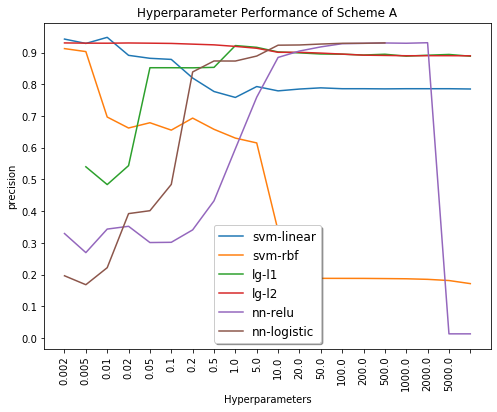

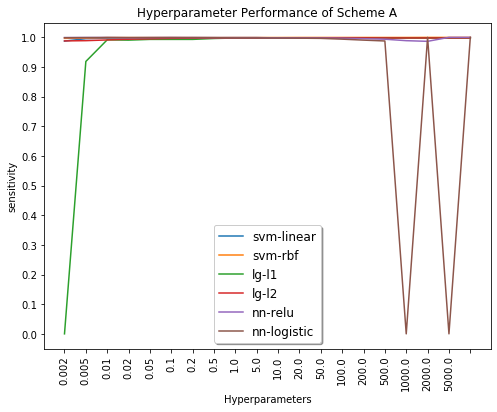

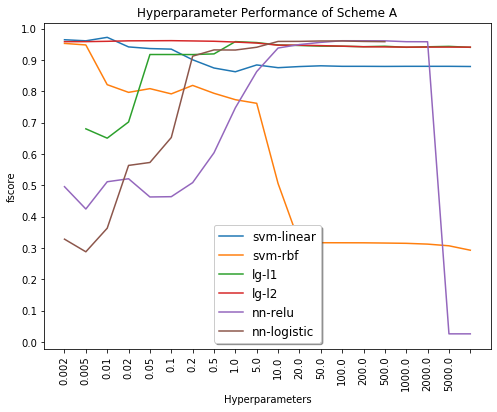

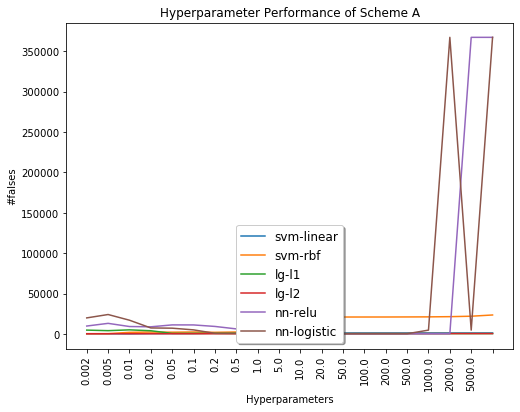

In [27]:
pl.show_plot(df_precision, "Hyperparameter Performance of Scheme A", "precision", "precision_schemeA_1.png")
pl.show_plot(df_sensitivity, "Hyperparameter Performance of Scheme A", "sensitivity", "sensitivity_schemeA_1.png")
pl.show_plot(df_fscore, "Hyperparameter Performance of Scheme A", "fscore", "fscore_schemeA_1.png")
pl.show_plot(df_nb_false, "Hyperparameter Performance of Scheme A", "#falses", "nb_false_schemeA_1.png")

In [32]:
df_precision.to_csv(PATH_OUTPUT + 'schemeA_precision_data.csv')
df_sensitivity.to_csv(PATH_OUTPUT + 'schemeA_sensitivity_data.csv')
df_fscore.to_csv(PATH_OUTPUT + 'schemeA_fscore_data.csv')
df_nb_false.to_csv(PATH_OUTPUT + 'schemeA_nb_false_data.csv')

In [61]:
## ENSEMBLE CLASSIFICATION AND EVALUATION

print("BAGGING PERFORMANCE:\n")
modeltypes = ['svm', 'nn', 'lg'] 
modeltypes_2 = ['linear', 'relu', 'l2']
modelparams = [0.005, 100, 0.2]

df_bagging = pd.DataFrame(columns = ['model', 'no_false', 'confusion_matrix', 'precision', 'sensitivity', 
                                            'no_links', 'F-score', 'true_pos', 'true_neg', 'false_pos', 'false_neg'])

nFold = 10
kf = KFold(n_splits=nFold)
model_raw_score = [0]*3
model_binary_score = [0]*3
model_i = 0

for model_i in range(3):
    modeltype = modeltypes[model_i]
    modeltype_2 = modeltypes_2[model_i]
    modelparam = modelparams[model_i]

    print(modeltype, "per fold:")
    iFold = 0
    result_fold = [0]*nFold
    final_eval_fold = [0]*nFold

    for train_index, valid_index in kf.split(X_train):
        X_train_fold = X_train[train_index]
        y_train_fold = y_train[train_index]
        md =  train_model(modeltype, modelparam, X_train_fold, y_train_fold, modeltype_2)
        result_fold[iFold] = classify(md, X_test)
        final_eval_fold[iFold] = evaluation(y_test, result_fold[iFold])
        print("Fold", str(iFold), final_eval_fold[iFold])
        iFold = iFold + 1
        
    bagging_raw_score = np.average(result_fold, axis=0)
    bagging_binary_score  = np.copy(bagging_raw_score)
    bagging_binary_score[bagging_binary_score > 0.5] = 1
    bagging_binary_score[bagging_binary_score <= 0.5] = 0
    bagging_eval = evaluation(y_test, bagging_binary_score)
    print(modeltype, "bagging:", bagging_eval)
    print('')
    model_raw_score[model_i] = bagging_raw_score
    model_binary_score[model_i] = bagging_binary_score

    model = modeltypes[model_i] + " - " + modeltypes_2[model_i] + " - " + str(modelparams[model_i])
    df_bagging.loc[model_i] =  [model] + [v for _, v in bagging_eval.items()]


BAGGING PERFORMANCE:

svm per fold:
Fold 0 {'no_false': 286, 'confusion_matrix': [4881, 273, 13, 366906], 'precision': 0.9470314318975553, 'sensitivity': 0.9973436861463016, 'no_links': 5154, 'F-score': 0.9715366242038217, 'true_pos': 4881, 'true_neg': 366906, 'false_pos': 273, 'false_neg': 13}
Fold 1 {'no_false': 276, 'confusion_matrix': [4881, 263, 13, 366916], 'precision': 0.9488724727838258, 'sensitivity': 0.9973436861463016, 'no_links': 5144, 'F-score': 0.972504482964734, 'true_pos': 4881, 'true_neg': 366916, 'false_pos': 263, 'false_neg': 13}
Fold 2 {'no_false': 260, 'confusion_matrix': [4881, 247, 13, 366932], 'precision': 0.9518330733229329, 'sensitivity': 0.9973436861463016, 'no_links': 5128, 'F-score': 0.9740570744362402, 'true_pos': 4881, 'true_neg': 366932, 'false_pos': 247, 'false_neg': 13}
Fold 3 {'no_false': 269, 'confusion_matrix': [4881, 256, 13, 366923], 'precision': 0.9501654662254234, 'sensitivity': 0.9973436861463016, 'no_links': 5137, 'F-score': 0.9731831322899013

In [60]:
modeltypes[model_i] + " - " + modeltypes_2[model_i] + " - " + str(modelparams[model_i])

'svm - linear - 0.005'

THEIR RESULTS - BAGGING PERFORMANCE:

svm per fold:
Fold 0 {'no_false': 238, 'confusion_matrix': [4880, 224, 14, 366955], 'precision': 0.9561128526645768, 'sensitivity': 0.9971393543114018, 'no_links': 5104, 'F-score': 0.9761952390478096}
Fold 1 {'no_false': 231, 'confusion_matrix': [4881, 218, 13, 366961], 'precision': 0.9572465189252795, 'sensitivity': 0.9973436861463016, 'no_links': 5099, 'F-score': 0.9768838186730712}
Fold 2 {'no_false': 241, 'confusion_matrix': [4881, 228, 13, 366951], 'precision': 0.9553728714034058, 'sensitivity': 0.9973436861463016, 'no_links': 5109, 'F-score': 0.9759072278316505}
Fold 3 {'no_false': 222, 'confusion_matrix': [4881, 209, 13, 366970], 'precision': 0.9589390962671905, 'sensitivity': 0.9973436861463016, 'no_links': 5090, 'F-score': 0.9777644230769231}
Fold 4 {'no_false': 226, 'confusion_matrix': [4881, 213, 13, 366966], 'precision': 0.958186101295642, 'sensitivity': 0.9973436861463016, 'no_links': 5094, 'F-score': 0.9773728474169004}
Fold 5 {'no_false': 228, 'confusion_matrix': [4881, 215, 13, 366964], 'precision': 0.9578100470957613, 'sensitivity': 0.9973436861463016, 'no_links': 5096, 'F-score': 0.9771771771771772}
Fold 6 {'no_false': 246, 'confusion_matrix': [4881, 233, 13, 366946], 'precision': 0.9544387954634337, 'sensitivity': 0.9973436861463016, 'no_links': 5114, 'F-score': 0.9754196642685851}
Fold 7 {'no_false': 243, 'confusion_matrix': [4881, 230, 13, 366949], 'precision': 0.9549990217178634, 'sensitivity': 0.9973436861463016, 'no_links': 5111, 'F-score': 0.975712143928036}
Fold 8 {'no_false': 265, 'confusion_matrix': [4880, 251, 14, 366928], 'precision': 0.9510816604950302, 'sensitivity': 0.9971393543114018, 'no_links': 5131, 'F-score': 0.97356608478803}
Fold 9 {'no_false': 251, 'confusion_matrix': [4881, 238, 13, 366941], 'precision': 0.9535065442469233, 'sensitivity': 0.9973436861463016, 'no_links': 5119, 'F-score': 0.9749325876360732}
svm bagging: {'no_false': 236, 'confusion_matrix': [4881, 223, 13, 366956], 'precision': 0.9563087774294671, 'sensitivity': 0.9973436861463016, 'no_links': 5104, 'F-score': 0.9763952790558111}

nn per fold:
Fold 0 {'no_false': 395, 'confusion_matrix': [4871, 372, 23, 366807], 'precision': 0.9290482548159451, 'sensitivity': 0.9953003677973028, 'no_links': 5243, 'F-score': 0.9610338364407616}
Fold 1 {'no_false': 392, 'confusion_matrix': [4872, 370, 22, 366809], 'precision': 0.9294162533384205, 'sensitivity': 0.9955046996322027, 'no_links': 5242, 'F-score': 0.9613259668508288}
Fold 2 {'no_false': 410, 'confusion_matrix': [4873, 389, 21, 366790], 'precision': 0.9260737362219689, 'sensitivity': 0.9957090314671025, 'no_links': 5262, 'F-score': 0.9596297755021662}
Fold 3 {'no_false': 395, 'confusion_matrix': [4872, 373, 22, 366806], 'precision': 0.928884652049571, 'sensitivity': 0.9955046996322027, 'no_links': 5245, 'F-score': 0.9610415228326266}
Fold 4 {'no_false': 391, 'confusion_matrix': [4872, 369, 22, 366810], 'precision': 0.929593589009731, 'sensitivity': 0.9955046996322027, 'no_links': 5241, 'F-score': 0.9614208189442526}
Fold 5 {'no_false': 408, 'confusion_matrix': [4873, 387, 21, 366792], 'precision': 0.926425855513308, 'sensitivity': 0.9957090314671025, 'no_links': 5260, 'F-score': 0.9598187906243844}
Fold 6 {'no_false': 406, 'confusion_matrix': [4873, 385, 21, 366794], 'precision': 0.9267782426778243, 'sensitivity': 0.9957090314671025, 'no_links': 5258, 'F-score': 0.9600078802206462}
Fold 7 {'no_false': 409, 'confusion_matrix': [4873, 388, 21, 366791], 'precision': 0.926249762402585, 'sensitivity': 0.9957090314671025, 'no_links': 5261, 'F-score': 0.95972427375677}
Fold 8 {'no_false': 394, 'confusion_matrix': [4873, 373, 21, 366806], 'precision': 0.928898208158597, 'sensitivity': 0.9957090314671025, 'no_links': 5246, 'F-score': 0.9611439842209073}
...
Fold 8 {'no_false': 904, 'confusion_matrix': [4877, 887, 17, 366292], 'precision': 0.8461138098542679, 'sensitivity': 0.996526358806702, 'no_links': 5764, 'F-score': 0.9151810846312628}
Fold 9 {'no_false': 947, 'confusion_matrix': [4878, 931, 16, 366248], 'precision': 0.8397314511964193, 'sensitivity': 0.9967306906416019, 'no_links': 5809, 'F-score': 0.9115201345417172}
lg bagging: {'no_false': 927, 'confusion_matrix': [4879, 912, 15, 366267], 'precision': 0.842514246244172, 'sensitivity': 0.9969350224765018, 'no_links': 5791, 'F-score': 0.9132428638277961}


In [62]:
thres = .99

print("STACKING PERFORMANCE:\n")
stack_raw_score = np.average(model_raw_score, axis=0)
stack_binary_score = np.copy(stack_raw_score)
stack_binary_score[stack_binary_score > thres] = 1
stack_binary_score[stack_binary_score <= thres] = 0
stacking_eval = evaluation(y_test, stack_binary_score)
print(stacking_eval)


model = "stack bagging"
df_bagging.loc[len(df_bagging)] =  [model] + [v for _, v in stacking_eval.items()]
df_bagging.to_csv(PATH_OUTPUT+'schemeA_bagging_stack.csv')

STACKING PERFORMANCE:

{'no_false': 204, 'confusion_matrix': [4869, 179, 25, 367000], 'precision': 0.964540412044374, 'sensitivity': 0.994891704127503, 'no_links': 5048, 'F-score': 0.9794809897404949, 'true_pos': 4869, 'true_neg': 367000, 'false_pos': 179, 'false_neg': 25}


THEIR RESULTS - STACKING PERFORMANCE:

{'no_false': 201, 'confusion_matrix': [4864, 171, 30, 367008], 'precision': 0.9660377358490566, 'sensitivity': 0.9938700449530037, 'no_links': 5035, 'F-score': 0.9797562695135462}

In [100]:
col = df_fscore.filter(like="nn")
score = []
for c in col:
    score.append(df_fscore[df_fscore[c] == df_fscore[c].max()][c].values)

max_score = np.max(score)
model = col.columns[score.index(max_score)]
param = df_fscore[df_fscore[model] == max_score]["param"].values[0]

print(model.split("-")[0])
print(model.split("-")[1])
print(param)



nn
relu
50.0
